# $d$-separation

$d$-separation is a key concept in causal inference. 

*Why is $d$-separation important?* Looking at [this page](http://bayes.cs.ucla.edu/BOOK-2K/d-sep.html) (by Pearl himself):

> $d$-separation is a criterion for deciding, from a given a causal graph, whether a set $X$ of variables is independent of another set $Y$, given a third set $S$. (I modified that last symbol for consistency here.)

In [25]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import networkx as nx
from custom import draw_graph

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


To get into $d$-separation, we first have to understand **paths** and **blocked paths**.

One thing that I didn't grok immediately when reading Judea Pearl's book on Causality was that the difference between a **path** and a **directed path**. For me, coming in with a fairly shallow network science background, I could not see how "a path" could be traced from $A$ to $D$ in the following graph:

$$A \rightarrow B \leftarrow C \rightarrow D$$

By simply traversing the graph from A, we can only ever arrive at B... right?

Yes, but only if we accept the traditional "network science" definitions of a path. In causal inference, a path is just any undirected connection between variables; a directed path, on the other hand, has to follow the directions on the edges. Therefore, we have to consider the "undirected" version of the graph:

$$A - B - C - D$$

Mechanically, what we are doing when we finding out whether two nodes $n_1$ and $n_2$ are $d$-separated or not is to first start with the undirected version of the causal graph, then find every single path between the two nodes in the undirected graph, then see if there are blockers to independence between $n_1$ and $n_2$ in the directed version of the graph (as determined by three rules, which I will go through below).

This notebook is going to be structured as a hybrid between "my notes from Jonas Peters' lecture series" and "an exercise in implementing algorithms" related to $d$-separation and inferring causal structures from observational data (under certain assumptions).

Let's say we have the following causal structure:

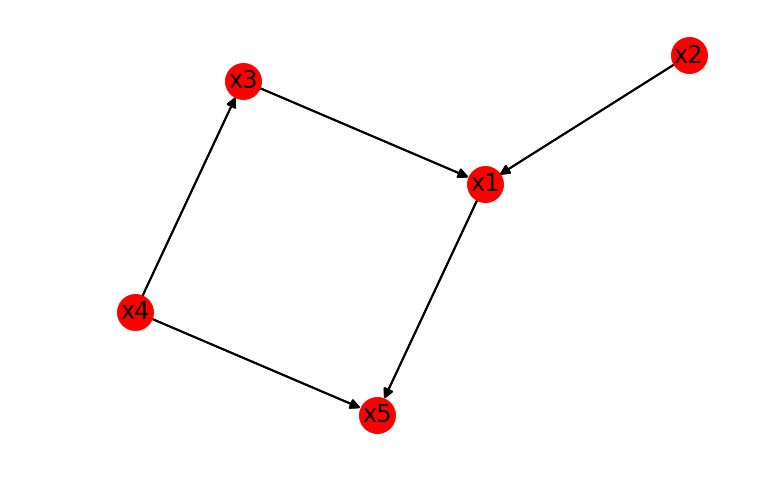

In [26]:
G = nx.DiGraph()
G.add_edge('x2', 'x1')
G.add_edge('x3', 'x1')
G.add_edge('x4', 'x3')
G.add_edge('x4', 'x5')
G.add_edge('x1', 'x5')
draw_graph(G)

There are some definitions that we have to get clear with.

- **Path:** Convert the graph to an undirected graph. Then ask if there is a connection between the two nodes or not.
- **Directed Path:** Follow the arrows!
- **V-structure:** An example in the above graph is $x_1$: it has two parents, $x_3$ and $x_2$ which are not connected by an arrow to each other.

From this, we then get to the definition of $d$-separation: Two nodes $x_i$ and $x_j$ are $d$-separated by the node set $S$ if all paths between $x_i$ and $x_j$ are blocked by the node set $S$.

We also call node set $S$ the "conditioning set".

There are three rules to determine this. For each node $n$ in $S$, we check whether it looks like the following:

1. $\rightarrow n \rightarrow$, where $n$ is in the conditioning set $S$,
1. $\leftarrow n \rightarrow$, where $n$ is in the conditioning set $S$
1. $\rightarrow n \leftarrow$, where $n$ is **not** in the conditioning set $S$ (these are the **v-structures**).

There is a supplemental rule:

1. If $n$ has a descendant that is in $S$, and $n$ is **not** in $S$, then then $x_i$ and $x_j$ are **not** $d$-separated.

(recall: don't follow the arrows, as we're not referring to directed paths)

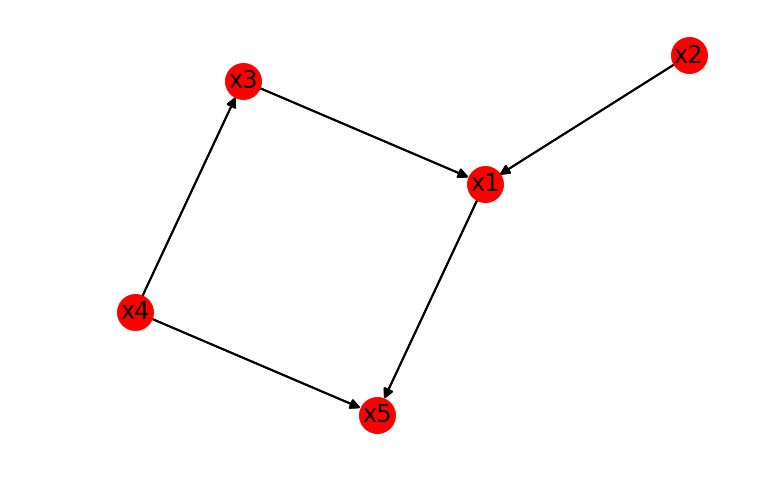

In [27]:
draw_graph(G)

## Example 1

Anchoring ourself in the above example, let's ask if $x_2$ and $x_5$ are $d$-separated by the node set $S = \{x_1, x_4\}$. 

1. $x_1$ lies on the path from $x_2$ to $x_5$, and looks like Rule \#1.
1. $x_4$ lies on the path from $x_2$ to $x_5$ (the path is $x_2 \rightarrow x_1 \leftarrow x_3 \leftarrow x_4 \rightarrow x_5$), and looks like Rule \#2.

Therefore, by rules \#1 and \#2, $\{x_2, x_5\}$ are $d$-separated by $S = \{x_1, x_4\}$.

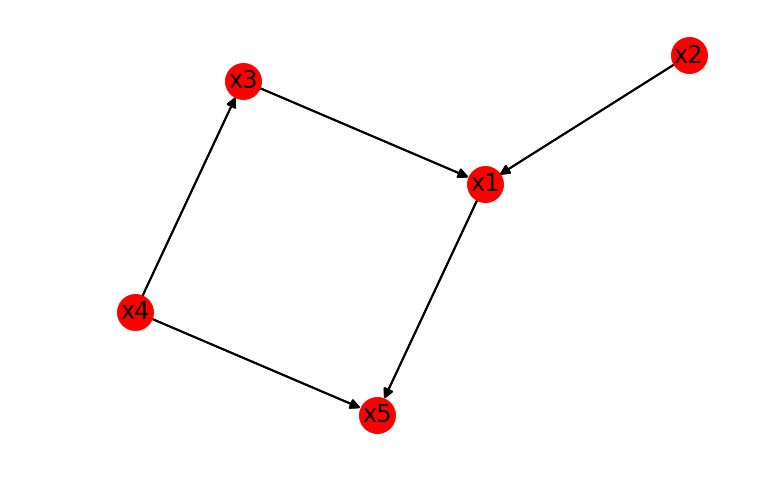

In [28]:
draw_graph(G)

## Example 2

Let's ask if $x_1$ and $x_4$ are $d$-separated by the node set $S = \{x_2, x_3\}$.

1. $x_2$ does not lie on a causal path from $x_1$ to $x_4$.
1. $x_3$ lies on a causal path from $x_1$ to $x_4$ (the path is $x_1 \leftarrow x_3 \leftarrow x_4$), and looks like Rule \#1.
1. The other path from $x_1$ to $x_4$ is $x_1 \rightarrow x_5 \leftarrow x_4$, and $x_5$ is not in the node set $S$, therefore this looks like Rule \#3.

Therefore, by rules \#1 and \#3, $\{x_1, x_4\}$ are $d$-separated by $S = \{x_2, x_3\}$.

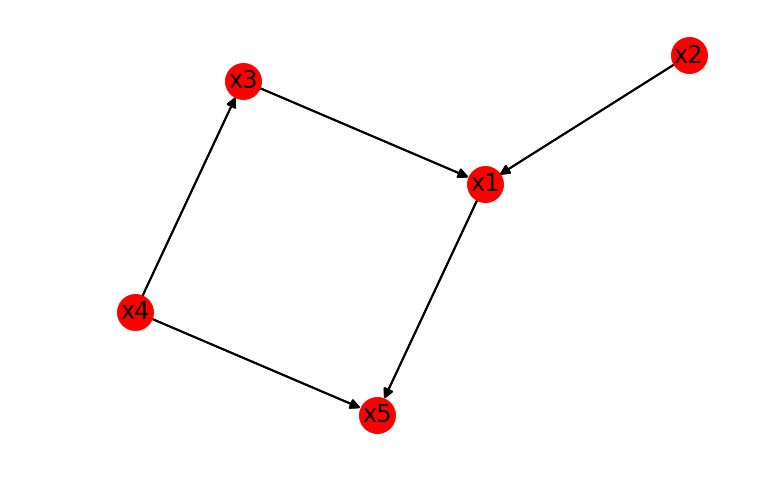

In [29]:
draw_graph(G)

## Example 3

Finally, let's ask if $x_2$ and $x_4$ are $d$-separated by the node set $S = \{\}$.

There are two sets of paths to go from $x_2$ to $x_4$:

1. $x_2 \rightarrow x_1 \rightarrow x_5 \leftarrow x_4$
1. $x_2 \rightarrow x_1 \leftarrow x_3 \leftarrow x_4$

In both cases, $x_1$ is not in node set $S=\{\}$, and looks like Rule \#3.

Therefore, by rule \#3, $x_2$ and $x_4$ are $d$-separated by $S = \{\}$.

# Algorithm

From the above examples, I think I have a way of writing an algorithm that can automatically check for $d$-separation.

Firstly, we have to define the three rules as functions.

In [30]:
from custom import rule1, rule2, rule3

In [31]:
rule1??

Signature: rule1(n, S, G, path)
Docstring:
Tells us if a node in the graph G satisfies
blocking rule 1 in the causal path provided.

Blocking rule 1 is:

    -> n ->
    
This is topologically equivalent to:

    <- n <-
    
Where n is a member of S.

:param n: A node in graph G.
:param S: The conditioning node set.
:param G: A NetworkX graph.
:param path: The causal path of interest.
Source:   
def rule1(n, S, G, path):
    """
    Tells us if a node in the graph G satisfies
    blocking rule 1 in the causal path provided.
    
    Blocking rule 1 is:
    
        -> n ->
        
    This is topologically equivalent to:
    
        <- n <-
        
    Where n is a member of S.
    
    :param n: A node in graph G.
    :param S: The conditioning node set.
    :param G: A NetworkX graph.
    :param path: The causal path of interest.
    """
    G_sub = path_nodes(G, path)
    in_conditioning_set = n in S
    has_in_edges = len(list(G_sub.in_edges(n))) == 1
    has_out_edges = len(li

In [32]:
rule2??

Signature: rule2(n, S, G, path)
Docstring:
Tells us if a node in the graph G satisfies
blocking rule 2 in the causal path provided.

Blocking rule 2 is:

    <- n ->
    
Where n is a member of S.

:param n: A node in graph G.
:param S: The conditioning node set.
:param G: A NetworkX graph.
:param path: The causal path of interest.
Source:   
def rule2(n, S, G, path):
    """
    Tells us if a node in the graph G satisfies
    blocking rule 2 in the causal path provided.
    
    Blocking rule 2 is:
    
        <- n ->
        
    Where n is a member of S.
    
    :param n: A node in graph G.
    :param S: The conditioning node set.
    :param G: A NetworkX graph.
    :param path: The causal path of interest.
    """
    G_sub = path_nodes(G, path)
    in_conditioning_set = n in S
    has_out_edges = len(list(G_sub.out_edges(n))) == 2
    return in_conditioning_set and has_out_edges
File:      ~/github/incubator/causality/notebooks/custom.py
Type:      function


In [33]:
rule3??

Signature: rule3(n, S, G, path)
Docstring:
Tells us if a node in the graph G satisfies
blocking rule 3 in the causal path provided.

Blocking rule 3 is as such:

If n is a collider:

    -> n <-
    
Then it is a blocker, otherwise it is not a blocker.

However, if n is a member of S, or n has a descendant
that is a member of S, then it is not a blocker.
    
:param n: A node in graph G.
:param S: The conditioning node set.
:param G: A NetworkX graph.
:param path: The causal path of interest.
Source:   
def rule3(n, S, G, path):
    """
    Tells us if a node in the graph G satisfies
    blocking rule 3 in the causal path provided.
    
    Blocking rule 3 is as such:
    
    If n is a collider:
    
        -> n <-
        
    Then it is a blocker, otherwise it is not a blocker.
    
    However, if n is a member of S, or n has a descendant
    that is a member of S, then it is not a blocker.
        
    :param n: A node in graph G.
    :param S: The conditioning node set.
    :par

Then, we define the $d$-separation algorithm:

In [34]:
def d_separation(n1, n2, S, G: nx.DiGraph):
    """
    Checks whether nodes n1 and n2 are d-separated by the set S.
    
    :param n1: A node in the graph G.
    :param n2: A node in the graph G.
    :param S: The conditioning set of interest.
    :param G: A NetworkX directed graph.
    :returns: (bool) dsep.
    """
    # Defensive programming checks.
    def error(n):
        """Custom error message for assertions below."""
        return f"node {n} not in graph G"
    
    assert n1 in G.nodes(), error(n1)
    assert n2 in G.nodes(), error(n1)
    for n in S:
        assert n in G.nodes(), error(n1)
    
    # First, we hold an undirected copy of the graph.
    Gpath = G.to_undirected()
    
    # Next, we check whether there is a path from node n1 to n2.
    assert nx.has_path(Gpath, n1, n2)
    
    # Next, we iterate over each path between n1 and n2, and check for the three rules.
    #
    # Any one of the three rules has to be fulfilled on a path for the path to be
    # blocked by the set S.
    #
    # However, blocking must occur on all paths, otherwise, the two nodes n1 and n2 are
    # not d-separated.
    paths_blocked = []
    for path in nx.all_simple_paths(G.to_undirected(), n1, n2):
        is_blocked = False
        for node in path:
            if node is not n1 and node is not n2:
                pass1 = rule1(node, S, G, path) 
                pass2 = rule2(node, S, G, path)
                pass3 = rule3(node, S, G, path)
                if (pass1 or pass2 or pass3):
                    is_blocked = True
        paths_blocked.append(is_blocked)
    return all(paths_blocked)
    

Finally, let's run the test cases.

From the examples above, $x_2$ and $x_5$ are $d$-separated by $\{x_1, x_4\}$:

In [35]:
d_separation('x2', 'x5', set(['x1', 'x4']), G)

True

Also, $x_1$ and $x_4$ are $d$-separated by $\{x_2, x_3\}$:

In [36]:
d_separation('x1', 'x4', set(['x2', 'x3']), G)

True

Finally, $x_2$ and $x_4$ are $d$-separated by $\{\}$ (an empty set of nodes):

In [37]:
d_separation('x2', 'x4', set([]), G)

True

Woohoo! 

The hard part about doing this manually is that it's difficult to manually enumerate all simple paths between two nodes on a graph. Like, tracing it and keeping it in memory is difficult. But implementing the rules as an algorithm helps.

A few more tests: Edges should not be $d$-separated.

In [38]:
for n1, n2 in G.edges():
    assert not d_separation(n1, n2, set([]), G)

## Example 4

Let's try a different causal graph, $G2$, which is part of [Example 3 in Pearl's $d$-separation without tears](http://bayes.cs.ucla.edu/BOOK-2K/d-sep.html).

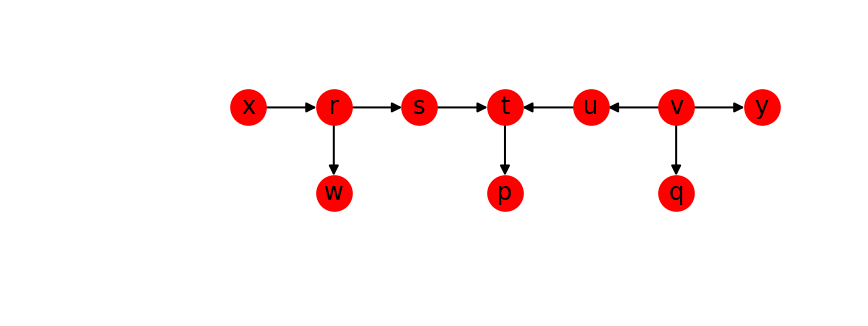

In [39]:
import matplotlib.pyplot as plt

G2 = nx.DiGraph()
edges = ['xr', 'rw', 'rs', 'st', 'tp', 'ut', 'vu', 'vq', 'vy']
edges = [(f'{i[0]}', f'{i[1]}') for i in edges]
G2.add_edges_from(edges)

fig = plt.figure()
ax = fig.add_subplot(111)
pos = {'x': (1, 0), 'r': (2, 0), 's': (3, 0), 't': (4, 0),
       'u': (5, 0), 'v': (6, 0), 'y': (7, 0), 'w': (2, -1),
       'p' : (4, -1), 'q': (6, -1)}
# pos = nx.spring_layout(G2)
nx.draw(G2, pos=pos, with_labels=True, ax=ax)
ax.set_aspect('equal')
ax.set_ylim(-2, 1)
ax.set_xlim(-1, 8)
plt.tight_layout()

In Pearl's page, he sets up a hypothetical regression of $y$ on $p$, $r$ and $x$:

$$y = c_1p + c_2r + c_3x$$

*A priori*, it is possible to know which regression coefficient is going to be zero, if we know the causal graph and assume that the relationship is linear.

To check whether $c_3$ will be zero, we ask whether $y$ and $x$ are $d$-separated by $\{p, r\}$:

In [40]:
d_separation('x', 'y', set(['r', 'p']), G2)

True

To check whether $c_1$ will be zero, we ask whether $y$ and $p$ are $d$-separated by $\{r, x\}$:

In [41]:
d_separation('p', 'y', set(['x', 'r']), G2)

False

To check whether $c_2$ will be zero, we ask whether $y$ and $r$ are $d$-separated by $\{x, p\}$:

In [42]:
d_separation('r', 'y', set(['x', 'p']), G2)

False

$y$ and $r$ are not $d$-separated (i.e. they are $d$-connected), because $t$, which is a collider (and would originally have blocked the path), has a descendant $p$ that is part of the conditioning set.

So, why is this important? It allows us to state a thing called the "Markov condition":

> The joint probability distribution $P$ between two variables $x_i$ and $x_j$ is Markov w.r.t. the graph $G$ if, for the conditioning set $S$:
>
> $x_i$ and $x_j$ are $d$-separated by $S$ in $G$.
>
> $\implies$ (implies) $x_i$ is conditionally independent of $x_j$, conditioned on $S$.